In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path

from preprocessing import preprocess_ecmwf, preprocess_target, preprocess_raw_forecasts, unprocessed_forecast
from cnn_training import generate_climprob_inputs, ModelRegistry, construct_climdev_cnn, DEFAULT_FIT, DEFAULT_COMPILE, DEFAULT_CONSTRUCT
from verification import l1yocv_climatology, brier_skill_score, reliability_diagram

In [4]:
list(Path('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/').glob('*.nc'))

[PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-gh-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-tcw-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-t2m-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sm20-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sm100-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sst-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-tp-week3456.nc')]

Among these are:
* 'total precipitation' (tp) of course
* but also 'total column water' (tcw)
* 'geopotential at 500 hPa' (gh)
* 'two-meter-temperature' (t2m)
* 'soil moisture 0-20 cm' (sm20)
* 'soil moisture 0-100 cm' (sm100)
* 'sea surface temperature' (sst). 

Further details in the attributes and here: https://confluence.ecmwf.int/display/S2S/Parameters  

A pre-aggregated (still gridded) target variable from CHRIPS is available in two spatial resolutions:

In [5]:
list(Path('/data/volume_2/observational/preprocessed/').glob('*4week*.nc'))

[PosixPath('/data/volume_2/observational/preprocessed/chirps_tp_2000-2020_4weekly_0.25deg_africa.nc')]

## Pre-processing data for the CNN
The current application takes in gridded patches centered over the Horn of Africa and predicts a scaler or categorical variable. The stack of patches can comprise multiple forecasted variables from ecmwf (like precipitation and temperature), all of the ensemble members, or summery statistics like the ensemble mean.
These multiple variable cannot be fed directly, but need to be standardized and put on the same scale. This is what pre-processing does. Several choices need to be made (and can be experimented with):
* removing the seasonal cycle?
* which variables to include?
* ensemble mean or members, or ...?
* standardize per grid point over time (i.e. remove climatological gradients) or standardize patch over space, per moment in time?

Also for the target choices need to be made:
* Over which masked spatial region do I average?
* What quantiles do I use for categorizing it?

In [2]:
scratchdir = Path('/scratch/cvanstraat/')
experiment_name = 'trial2_ensmean'
ensmean = True
varlist = ['tp','sst','tcw']

# Construction of Patched inputs
training_inputs = {key:[] for key in varlist}  # These will be hindcasts
testing_inputs = {key:[] for key in varlist}  # These will be forecasts (though probably more testing data will be generated through crossvalidation of hindcasts)
for var in varlist:
    if var == 'tp': # No seasonal anomalies
        hindcast, forecast = preprocess_ecmwf(var = var, rm_season = False, ensmean = ensmean, standardize_space = False, standardize_time = True) # No seasonal removal for rainfall? Perhaps rainfall should be min-max scaled, such that zero is really zero?
    else:
        hindcast, forecast = preprocess_ecmwf(var = var, rm_season = True, ensmean = ensmean, standardize_space = False, standardize_time = True)
    training_inputs[var] = hindcast.expand_dims({'variable':[var]})
    testing_inputs[var] = forecast.expand_dims({'variable':[var]})

training_inputs = xr.concat(training_inputs.values(), dim = 'variable') # This already stacks the arrays into nchannels = nvariables 
testing_inputs = xr.concat(testing_inputs.values(), dim = 'variable')

training_inputs = training_inputs.rename({'variable':'channels'})
testing_inputs = testing_inputs.rename({'variable':'channels'})

training_inputs = training_inputs.transpose('valid_time','latitude','longitude','channels')
testing_inputs = testing_inputs.transpose('valid_time','latitude','longitude','channels')

# Unprocessed forecast
raw_training = {key:[] for key in varlist}  # These will be hindcasts
raw_testing = {key:[] for key in varlist} 

for var in varlist:
    if var == 'tp': # No seasonal anomalies
        hindcast, forecast = unprocessed_forecast(var = var, ensmean = ensmean) # No seasonal removal for rainfall? Perhaps rainfall should be min-max scaled, such that zero is really zero?
    else:
        hindcast, forecast = unprocessed_forecast(var = var, ensmean = ensmean)
    raw_training[var] = hindcast.expand_dims({'variable':[var]})
    raw_testing[var] = forecast.expand_dims({'variable':[var]})

raw_training = xr.concat(raw_training.values(), dim = 'variable').rename({'variable':'channels'}).transpose('valid_time','latitude','longitude','channels') # This already stacks the arrays into nchannels = nvariables 
raw_testing = xr.concat(raw_testing.values(), dim = 'variable').rename({'variable':'channels'}).transpose('valid_time','latitude','longitude','channels')

attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
standardization is temporal
computing standard scaler on (1060, 729), members as samples = False
standardization is temporal
using pre-trained standard scaler on (53, 729), members as samples = False
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
computing seasonality of individual members, members treated as extra samples for the climate
seasonal expectation is presupplied
standardization is temporal
computing standard scaler on (1060, 729), members as samples = False
standardization is temporal
using pre-trained standard scaler on (53, 729), members as samples = False


/home/cvanstraat/VENV/lib/python3.9/site-packages/sklearn/utils/extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/cvanstraat/VENV/lib/python3.9/site-packages/sklearn/utils/extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/cvanstraat/VENV/lib/python3.9/site-packages/sklearn/utils/extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
computing seasonality of individual members, members treated as extra samples for the climate
seasonal expectation is presupplied
standardization is temporal
computing standard scaler on (1060, 729), members as samples = False
standardization is temporal
using pre-trained standard scaler on (53, 729), members as samples = False
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), lon:slice(20.496000000000002, 60.496, None)
attempt patch selection lat:slice(24.511, -15.489, None), 

In [3]:
training_inputs

<xarray.DataArray (valid_time: 1060, latitude: 27, longitude: 27, channels: 3)>
array([[[[ 1.27595329e+00,             nan,  5.89597344e-01],
         [ 4.18961287e+00,             nan,  5.62893629e-01],
         [ 4.93520021e+00,             nan,  5.03515303e-01],
         ...,
         [ 3.61065149e-01,             nan, -2.51684576e-01],
         [ 4.33218747e-01,  7.06644207e-02, -2.92211205e-01],
         [ 1.06855285e+00, -1.19219072e-01, -3.32214504e-01]],

        [[ 3.48086810e+00,             nan,  5.09564579e-01],
         [ 1.68230307e+00,             nan,  4.38417733e-01],
         [ 3.20361304e+00,             nan,  3.92758727e-01],
         ...,
         [-6.70587301e-01,             nan, -4.42235172e-01],
         [ 9.85609114e-01,             nan, -4.92079467e-01],
         [ 6.23012722e-01, -9.14772674e-02, -4.55094576e-01]],

        [[ 2.08207774e+00,             nan,  3.03279042e-01],
         [-3.11419845e-01,             nan,  2.55832046e-01],
         [ 9.19375956e-01,             nan,  2.11420208e-01],
         ...,
...
         [ 2.70707822e+00,  1.65606117e+00,  1.69318855e+00],
         [ 2.70786405e+00,  1.79225683e+00,  1.71131015e+00],
         [ 3.01465678e+00,  1.71827972e+00,  1.83204126e+00]],

        [[ 3.08689952e-01,             nan,  8.72330666e-01],
         [ 6.36924624e-01,             nan,  9.98284578e-01],
         [ 2.74378657e-01,             nan,  1.13278687e+00],
         ...,
         [ 2.41777396e+00,  1.63925934e+00,  1.74212432e+00],
         [ 2.65642762e+00,  1.80082774e+00,  1.75876164e+00],
         [ 2.96962333e+00,  1.89903033e+00,  1.85397649e+00]],

        [[ 5.96471250e-01,             nan,  9.17758405e-01],
         [ 8.81503522e-01,             nan,  1.03630590e+00],
         [ 1.08688319e+00,             nan,  1.22166204e+00],
         ...,
         [ 2.06611228e+00,  1.59236443e+00,  1.79780459e+00],
         [ 2.43989635e+00,  1.75685823e+00,  1.93436933e+00],
         [ 2.59523630e+00,  1.86753654e+00,  2.04278684e+00]]]],
      dtype=float32)
Coordinates:
    month       (valid_time) int64 1 1 1 2 2 2 2 3 3 ... 11 11 12 12 12 12 1 1 1
  * channels    (channels) object 'tp' 'sst' 'tcw'
  * latitude    (latitude) float64 24.0 22.5 21.0 19.5 ... -12.0 -13.5 -15.0
  * longitude   (longitude) float64 21.0 22.5 24.0 25.5 ... 55.5 57.0 58.5 60.0
  * valid_time  (valid_time) datetime64[ns] 2000-01-17 2000-01-24 ... 2020-01-15

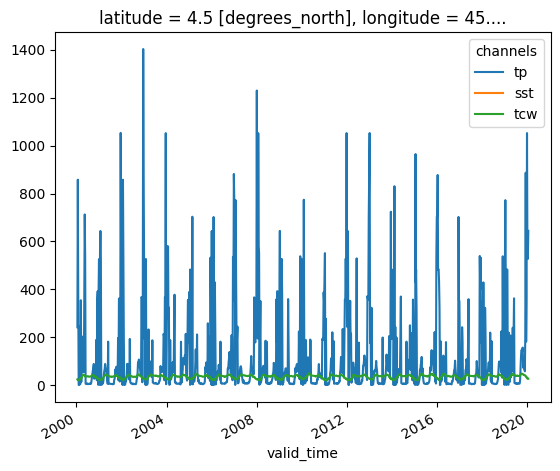

In [15]:
raw_training[:,13,16,:].plot.line(x='valid_time')

/home/cvanstraat/VENV/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


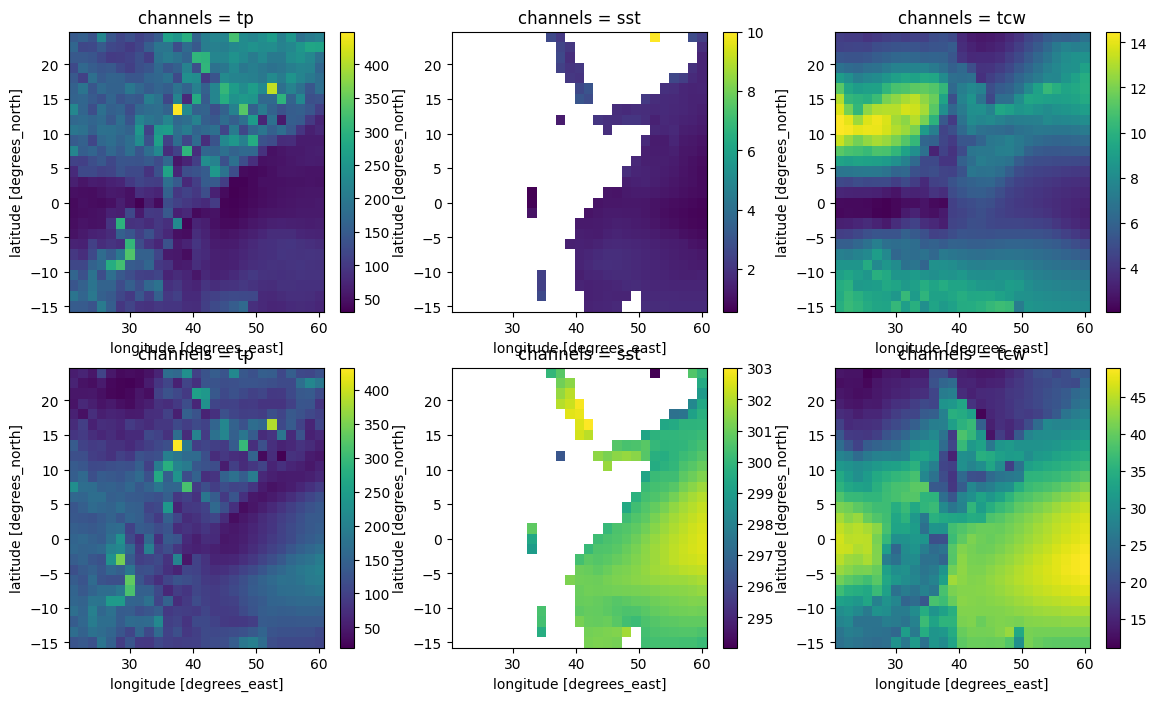

In [25]:
fig, axes = plt.subplots(ncols = len(varlist), nrows = 2, figsize = (14,8))
for i, var in enumerate(raw_training.channels):
    raw_training.sel(channels = var).std('valid_time').plot.pcolormesh(ax = axes[0,i],add_colorbar = True)
    raw_training.sel(channels = var).mean('valid_time').plot.pcolormesh(ax = axes[1,i],add_colorbar = True)

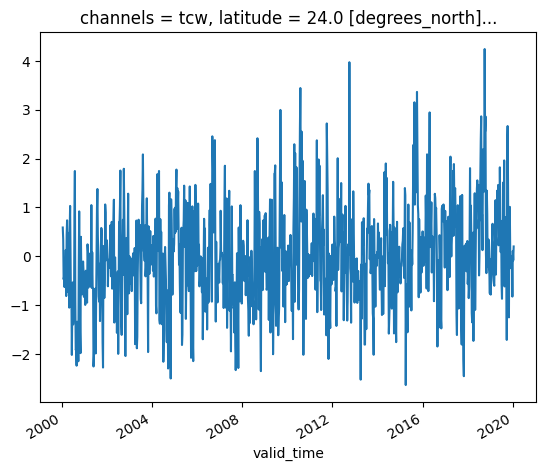

In [7]:
training_inputs[:,0,0,2].plot()

In [53]:
# Extract predictions by the CNN's, and create pandas from observations
cnnpreds = registry.make_predictions('test') # This contains predictions by all models (also untrained ones if you have not trained all that you've added)
verifying_obs = pd.DataFrame(full_target, index = full_timestamps.index, columns = full_benchmark.columns) # This is the fullset, one-hot-encoded
#verifying_obs =  # Samples are in multiple validation sets so reindex to make obs align with preds

In [54]:
# Note length difference in cnnpreds as nested cv causes each test year to occur 7 times.
print(len(verifying_obs),len(cnnpreds))

1113 7791


raw BSS:  0.07039831913471006


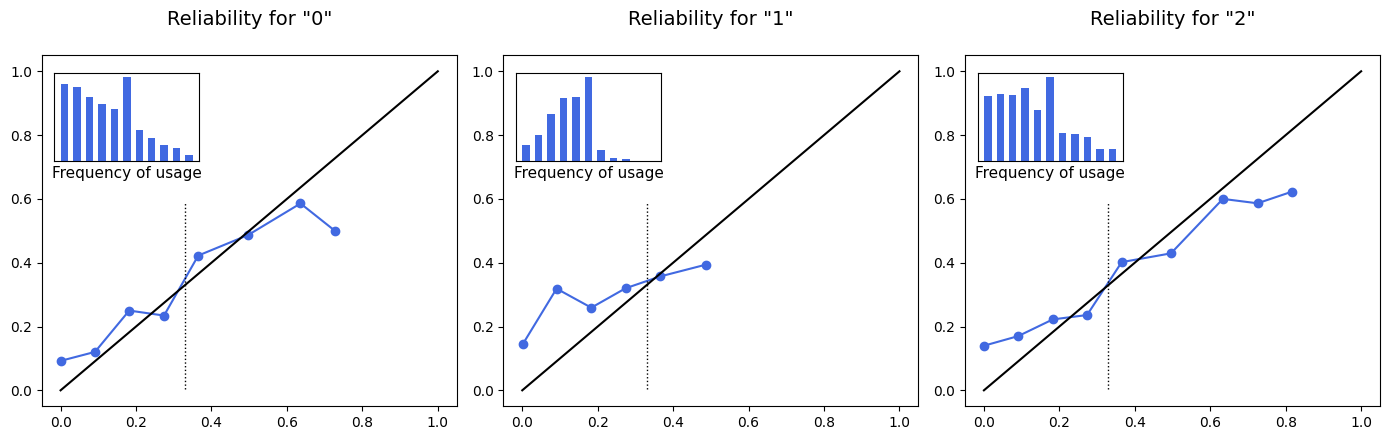

In [60]:
# raw forecasts relative to simple (leave 1 year out) climatology
clim_benchmark = l1yocv_climatology(verifying_obs)
print('raw BSS: ', brier_skill_score(y = verifying_obs, x = full_benchmark, x0 = clim_benchmark))
fig, ax = reliability_diagram(y = verifying_obs, x = full_benchmark)
plt.show()

cnn BSS:  0.11086070996274244


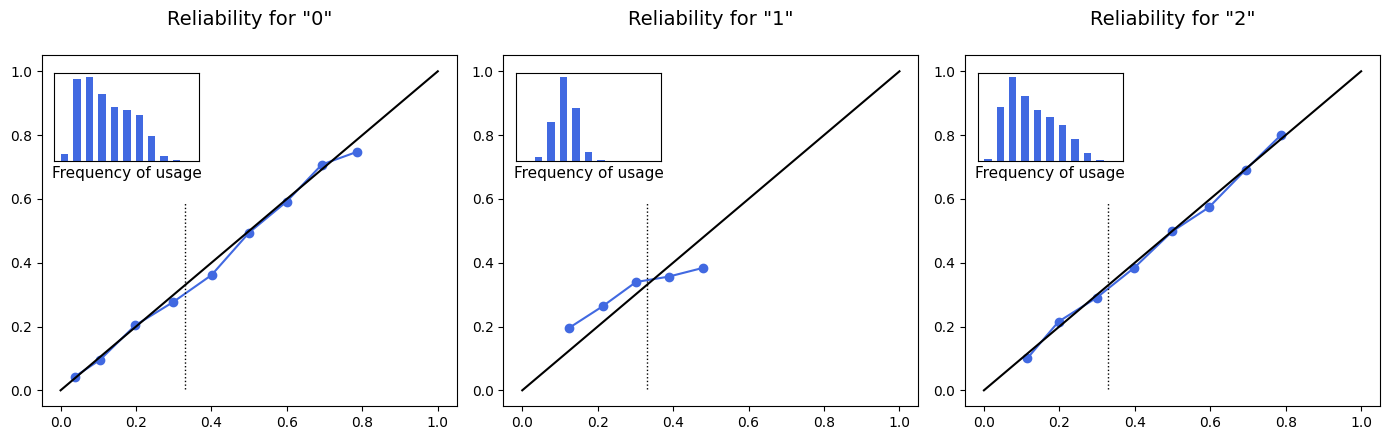

In [61]:
# Cnn forecasts relative to simple climatology
lengthened_obs = verifying_obs.reindex(cnnpreds.index)
clim_benchmark = l1yocv_climatology(lengthened_obs)
print('cnn BSS: ', brier_skill_score(y = lengthened_obs, x = cnnpreds, x0 = clim_benchmark))
fig, ax = reliability_diagram(y = lengthened_obs, x = cnnpreds)
plt.show()